<div align="center" style="font-size: 2rem">

<img heoght="300px" src="https://cta-observatory.github.io/ctapipe/_images/ctapipe_logo.png" alt="ctapipe"/>


<p style="text-align: center;">LST Analysis Bootcamp</p>

<p style="text-align: center">Padova, 26.11.2018</p>

<p style="text-align: center">Maximilian Nöthe (@maxnoe) & Kai A. Brügge (@mackaiver)</p>

</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 14

plt.rcParams['figure.figsize']

[12.0, 8.0]

In [3]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# General Information

## Design

* DL0 → DL3 analysis

* Currently some R0 → DL0 code to be able to analyze simtel files

* ctapipe is built upon the Scientific Python Stack, core dependencies are
  * numpy
  * scipy
  * astropy

## Developement

* ctapipe is developed as Open Source Software (Currently under MIT License) at <https://github.com/cta-observatory/ctapipe>

* We use the "Github-Workflow": 
  * Few people (e.g. @kosack, @mackaiver) have write access to the main repository
  * Contributors fork the main repository and work on branches
  * Pull Requests are merged after Code Review and automatic execution of the test suite

* Early developement stage ⇒ backwards-incompatible API changes might and will happen 

* Many open design questions ⇒ Core Developer Meeting in the second week of December in Dortmund

## What's there?

* Reading simtel simulation files
* Simple calibration, cleaning and feature extraction functions
* Camera and Array plotting
* Coordinate frames and transformations 
* Stereo-reconstruction using line intersections
  
 

## What's still missing?

* Easy to use IO of analysis results to standard data formats (e.g. FITS, hdf5)
* Easy to use "analysis builder"
* A "Standard Analysis"
* Good integration with machine learning techniques
* IRF calculation 
* Defining APIs for IO, instrument description access etc.
* Most code only tested on HESSIO simulations
* Documentation, e.g. formal definitions of coordinate frames 
 
 

## What can you do?

* Report issues
  * Hard to get started? Tell us where you are stuck
  * Tell user stories
  * Missing features

* Start contributing
  * ctapipe needs more workpower
  * Implement new reconstruction features

# A simple hillas analysis

## Reading in simtel files

In [4]:
from ctapipe.io import event_source
from ctapipe.utils.datasets import get_dataset_path

input_url = get_dataset_path('gamma_test_large.simtel.gz')

# `event_source()` automatically detects what kind of file we are giving it,
# if already supported by ctapipe
source = event_source(input_url, max_events=9)

print(type(source))

<class 'ctapipe.io.simteleventsource.SimTelEventSource'>


In [5]:
for event in source:
    print('Id: {}, E = {:1.3f}, Telescopes: {}'.format(event.count, event.mc.energy, len(event.r0.tel)))

Id: 0, E = 0.571 TeV, Telescopes: 4
Id: 1, E = 1.864 TeV, Telescopes: 9
Id: 2, E = 1.864 TeV, Telescopes: 4
Id: 3, E = 1.864 TeV, Telescopes: 17
Id: 4, E = 1.864 TeV, Telescopes: 2
Id: 5, E = 0.464 TeV, Telescopes: 7
Id: 6, E = 0.017 TeV, Telescopes: 2
Id: 7, E = 76.426 TeV, Telescopes: 4
Id: 8, E = 76.426 TeV, Telescopes: 16


Each event is a `DataContainer` holding several `Field`s of data, which can be containers or just numbers.
Let's look a one event:

In [6]:
event

ctapipe.io.containers.DataContainer:
                          r0.*: Raw Data
                          r1.*: R1 Calibrated Data
                         dl0.*: DL0 Data Volume Reduced Data
                         dl1.*: DL1 Calibrated image
                         dl2.*: Reconstructed Shower Information
                          mc.*: Monte-Carlo data
                    mcheader.*: Monte-Carlo run header data
                        trig.*: central trigger information
                         count: number of events processed
                        inst.*: instrumental information (deprecated
                   pointing[*]: Telescope pointing positions

In [7]:
event.inst.subarray.camera_types

['LSTCam', 'FlashCam', 'ASTRICam']

In [8]:
len(event.r0.tel), len(event.r1.tel)

(16, 0)

## Data calibration

As we saw, the data container only contains raw data (only the `r0` containers are filled)

So we use the `CameraCalibrator` factory to calibrate the event.

In [9]:
from ctapipe.calib import CameraCalibrator

calibrator = CameraCalibrator(
    eventsource=source,
)

In [10]:
calibrator.r1

In [11]:
calibrator.calibrate(event)

## Event displays

Let's use ctapipe's plotting facilities to plot the telescope images

In [12]:
event.dl1.tel.keys()

dict_keys([32, 33, 65, 35, 41, 10, 45, 15, 17, 18, 22, 23, 57, 27, 29, 31])

In [13]:
tel_id = 15


In [14]:
camera = event.inst.subarray.tel[tel_id].camera
dl1 = event.dl1.tel[tel_id]

camera, dl1

(CameraGeometry(cam_id='FlashCam', pix_type='hexagonal', npix=1764, cam_rot=0.0 deg, pix_rot=30.0 deg),
 ctapipe.io.containers.DL1CameraContainer:
                          image: np array of camera image, after waveform
                                 integration (N_pix)
                   gain_channel: boolean numpy array of which gain channel was
                                 used for each pixel in the image
              extracted_samples: numpy array of bools indicating which samples
                                 were included in the charge extraction as a
                                 result of the charge extractor chosen.
                                 Shape=(nchan, npix, nsamples).
                        peakpos: numpy array containing position of the peak as
                                 determined by the peak-finding algorithm for
                                 each pixel
                        cleaned: numpy array containing the waveform after
            

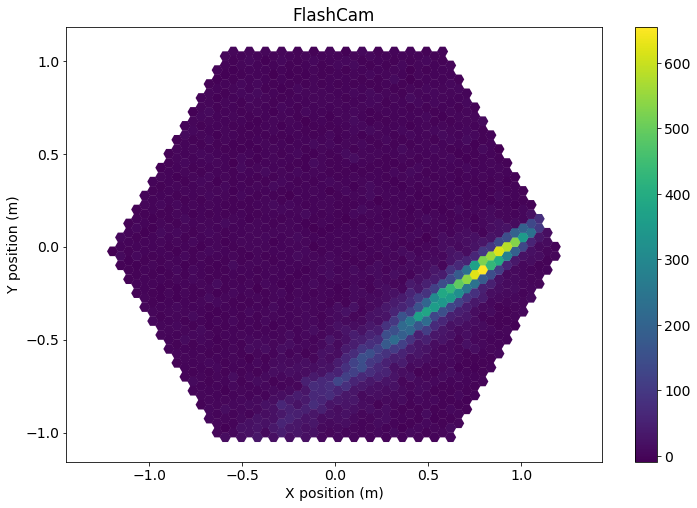

In [15]:
from ctapipe.visualization import CameraDisplay

display = CameraDisplay(camera)

# right now, there might be one image per gain channel.
# This will change as soon as 
display.image = dl1.image[0]
display.add_colorbar()

## Image Cleaning

In [16]:
from ctapipe.image.cleaning import tailcuts_clean

In [17]:
# unoptimized cleaning levels, copied from 
# https://github.com/tudo-astroparticlephysics/cta_preprocessing
cleaning_level = {
    'ASTRICam': (5, 7, 2),  # (5, 10)?
    'LSTCam': (3.5, 7.5, 2),  # ?? (3, 6) for Abelardo...
    'FlashCam': (4, 8, 2),  # there is some scaling missing?
}

In [18]:
boundary, picture, min_neighbors = cleaning_level[camera.cam_id]

clean = tailcuts_clean(
    camera, 
    dl1.image[0],
    boundary_thresh=boundary,
    picture_thresh=picture,
    min_number_picture_neighbors=min_neighbors
)

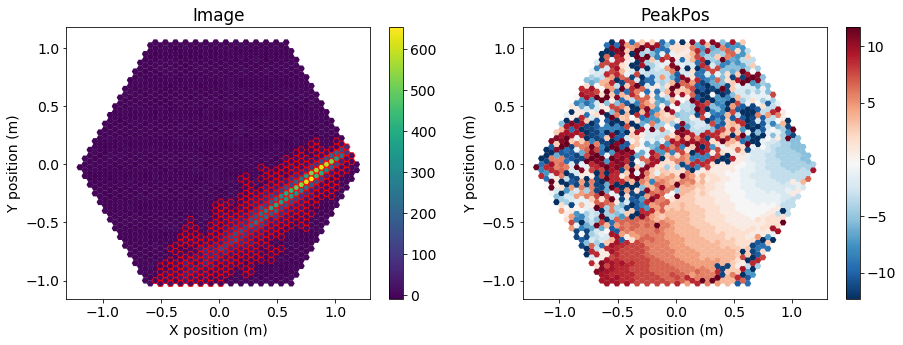

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

d1 = CameraDisplay(camera, ax=ax1)
d2 = CameraDisplay(camera, ax=ax2)

ax1.set_title('Image')
d1.image = dl1.image[0]
d1.add_colorbar(ax=ax1)

ax2.set_title('PeakPos')
d2.image = dl1.peakpos[0] - np.average(dl1.peakpos[0], weights=dl1.image[0])
d2.cmap = 'RdBu_r'
d2.add_colorbar(ax=ax2)

d1.highlight_pixels(clean, color='red', linewidth=1)

## Image Parameters

In [ ]:
from ctapipe.image import hillas_parameters, leakage, concentration
from ctapipe.image.timing_parameters import timing_parameters
from ctapipe.image.cleaning import number_of_islands

In [ ]:
hillas = hillas_parameters(camera[clean], dl1.image[0][clean])

print(hillas)

{'intensity': 27151.758956931313,
 'kurtosis': 2.6340018673205154,
 'length': <Quantity 0.43595734 m>,
 'phi': <Angle -0.53365387 rad>,
 'psi': <Angle 0.65739518 rad>,
 'r': <Quantity 0.61580729 m>,
 'skewness': -0.6140171751521407,
 'width': <Quantity 0.07600082 m>,
 'x': <Quantity 0.53018185 m>,
 'y': <Quantity -0.31325042 m>}


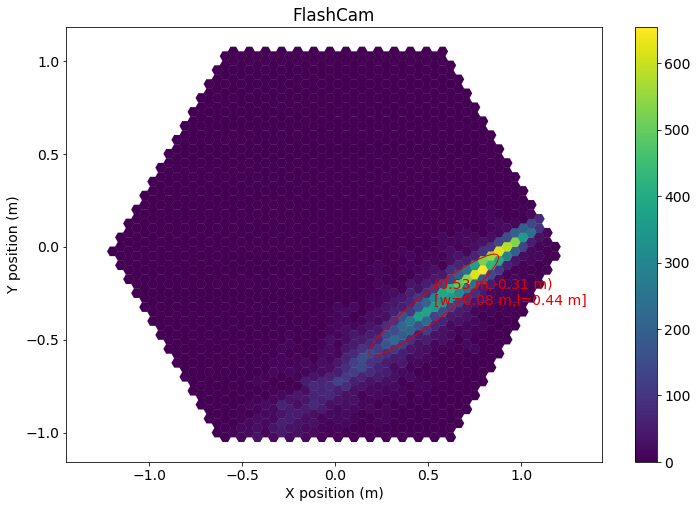

In [ ]:
display = CameraDisplay(camera)

# set "unclean" pixels to 0
cleaned = dl1.image[0].copy()
cleaned[~clean] = 0.0

display.image = cleaned
display.add_colorbar()

display.overlay_moments(hillas, color='xkcd:red')

In [ ]:
timing = timing_parameters(
    camera[clean],
    dl1.image[0][clean],
    dl1.peakpos[0][clean],
    hillas,
)

print(timing)

{'intercept': 12.285017061346267, 'slope': <Quantity -7.59392097 1 / m>}


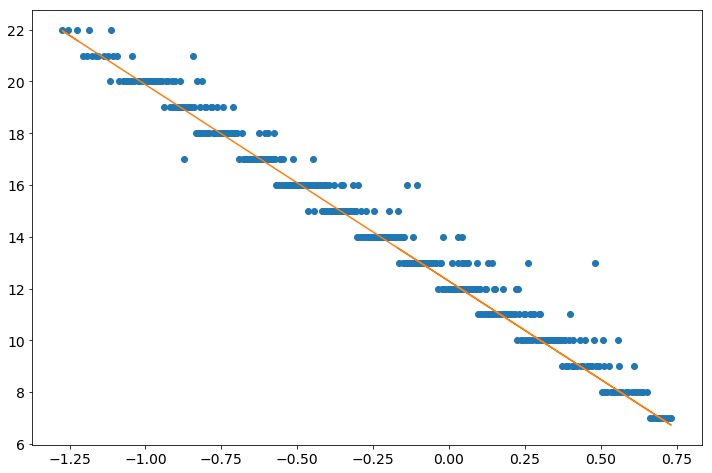

In [ ]:
long, trans = camera.get_shower_coordinates(hillas.x, hillas.y, hillas.psi)

plt.plot(long[clean], dl1.peakpos[0][clean], 'o')
plt.plot(long[clean], timing.slope * long[clean] + timing.intercept)

In [ ]:
l = leakage(camera, dl1.image[0], clean)
print(l)

{'leakage1_intensity': 0.017067592570373782,
 'leakage1_pixel': 0.01020408163265306,
 'leakage2_intensity': 0.04572030062200985,
 'leakage2_pixel': 0.023809523809523808}


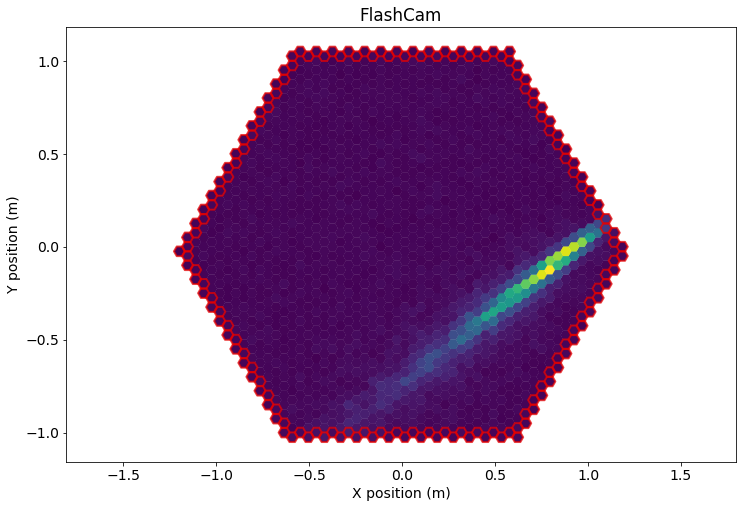

In [ ]:
disp = CameraDisplay(camera)
disp.image = dl1.image[0]
disp.highlight_pixels(camera.get_border_pixel_mask(1), linewidth=2, color='xkcd:red')

In [ ]:
n_islands, island_id = number_of_islands(camera, clean)

print(n_islands)

1


In [ ]:
conc = concentration(camera, dl1.image[0], hillas)
print(conc)

{'concentration_cog': 0.03213762270793535,
 'concentration_core': 0.46296381690959243,
 'concentration_pixel': 0.024114245525298825}


## Putting it all together / Stereo reconstruction

In [ ]:
import astropy.units as u

from ctapipe.io import event_source
from ctapipe.utils.datasets import get_dataset_path

from ctapipe.calib import CameraCalibrator

from ctapipe.image.cleaning import tailcuts_clean, number_of_islands
from ctapipe.image import hillas_parameters, leakage, concentration
from ctapipe.image.timing_parameters import timing_parameters

from ctapipe.reco import HillasReconstructor

from ctapipe.io import HDF5TableWriter

from copy import deepcopy
import tempfile

# unoptimized cleaning levels, copied from 
# https://github.com/tudo-astroparticlephysics/cta_preprocessing
cleaning_level = {
    'ASTRICam': (5, 7, 2),  # (5, 10)?
    'LSTCam': (3.5, 7.5, 2),  # ?? (3, 6) for Abelardo...
    'FlashCam': (4, 8, 2),  # there is some scaling missing?
}


input_url = get_dataset_path('gamma_test_large.simtel.gz')
source = event_source(input_url)

calibrator = CameraCalibrator(
    eventsource=source,
)

reco = HillasReconstructor()

f = tempfile.NamedTemporaryFile(suffix='.hdf5')

with HDF5TableWriter(f.name, mode='w', group_name='events') as writer:
    
    for event in source:
        print('Id: {}, E = {:1.3f}, Telescopes: {}'.format(event.count, event.mc.energy, len(event.r0.tel)))
        
        calibrator.calibrate(event)

        # mapping of telescope_id to parameters for stereo reconstruction
        hillas_containers = {}
        pointing_azimuth = {}
        pointing_altitude = {}
        time_gradients = {}

        for telescope_id, dl1 in event.dl1.tel.items():
            camera = event.inst.subarray.tels[telescope_id].camera
            image = dl1.image[0]
            peakpos = dl1.peakpos[0]

            boundary, picture, min_neighbors = cleaning_level[camera.cam_id]

            clean = tailcuts_clean(
                camera, 
                image,
                boundary_thresh=boundary,
                picture_thresh=picture,
                min_number_picture_neighbors=min_neighbors
            )

            # require more than five pixels after cleaning in each telescope
            if clean.sum() < 5:
                continue

            hillas_c = hillas_parameters(camera[clean], image[clean])
            leakage_c = leakage(camera, image, clean)
            n_islands, island_ids = number_of_islands(camera, clean)

            # remove events with high leakage
            if leakage_c.leakage2_intensity > 0.2:
                continue

            timing_c = timing_parameters(camera[clean], image[clean], peakpos[clean], hillas_c)

            hillas_containers[telescope_id] = hillas_c

            # ssts have no timing in prod3b, so we'll use the skewness
            time_gradients[telescope_id] = timing_c.slope.value if camera.cam_id != 'ASTRICam' else hillas_c.skewness

            # this makes sure, that we get an arrow in the array plow for each telescope
            # might have the wrong direction though
            if abs(time_gradients[telescope_id]) < 0.2:
                time_gradients[telescope_id] = 1.0

            pointing_azimuth[telescope_id] = event.mc.tel[telescope_id].azimuth_raw * u.rad
            pointing_altitude[telescope_id] = event.mc.tel[telescope_id].altitude_raw * u.rad

        if len(hillas_containers) > 1:
            stereo = reco.predict(
                hillas_containers, event.inst, pointing_altitude, pointing_azimuth
            )

            writer.write('reconstructed', stereo)
            writer.write('true', event.mc)
    
            print('  Alt: {:.2f}°'.format(stereo.alt.deg))
            print('  Az: {:.2f}°'.format(stereo.az.deg))
            print('  Hmax: {:.0f}'.format(stereo.h_max))
            print('  CoreX: {:.1f}'.format(stereo.core_x))
            print('  CoreY: {:.1f}'.format(stereo.core_y))
        
        # save a nice event for plotting later
        if event.count == 3:
            plotting_event = deepcopy(event)
            plotting_hillas = hillas_containers
            plotting_timing = time_gradients
            plotting_stereo = stereo
    

Id: 0, E = 0.571 TeV, Telescopes: 4
  Alt: 66.37°
  Az: -7.85°
  Hmax: 8963 m
  CoreX: 114.8 m
  CoreY: -414.8 m
Id: 1, E = 1.864 TeV, Telescopes: 9


/home/dneise/cta/ctapipe/ctapipe/coordinates/horizon_frame.py:28: UserWarning: Horizontal coordinate has no obstime, assuming same frame
  warnings.warn('Horizontal coordinate has no obstime, assuming same frame')
/home/dneise/cta/ctapipe/ctapipe/coordinates/horizon_frame.py:33: UserWarning: Horizontal coordinate has no location, assuming same frame
  warnings.warn('Horizontal coordinate has no location, assuming same frame')


  Alt: 68.26°
  Az: -353.38°
  Hmax: 6759 m
  CoreX: -47.1 m
  CoreY: -387.1 m
Id: 2, E = 1.864 TeV, Telescopes: 4
  Alt: 68.52°
  Az: -354.24°
  Hmax: 7110 m
  CoreX: -411.4 m
  CoreY: -553.7 m
Id: 3, E = 1.864 TeV, Telescopes: 17
  Alt: 68.49°
  Az: -353.30°
  Hmax: 6611 m
  CoreX: 88.0 m
  CoreY: 5.2 m
Id: 4, E = 1.864 TeV, Telescopes: 2
  Alt: 68.66°
  Az: -353.31°
  Hmax: 6305 m
  CoreX: -1095.7 m
  CoreY: 474.8 m
Id: 5, E = 0.464 TeV, Telescopes: 7
  Alt: 71.91°
  Az: -1.05°
  Hmax: 8682 m
  CoreX: -66.8 m
  CoreY: 290.3 m
Id: 6, E = 0.017 TeV, Telescopes: 2
  Alt: 70.47°
  Az: -359.53°
  Hmax: 10847 m
  CoreX: -172.4 m
  CoreY: -325.4 m
Id: 7, E = 76.426 TeV, Telescopes: 4
  Alt: 74.39°
  Az: -354.32°
  Hmax: 8621 m
  CoreX: 62.6 m
  CoreY: -1128.0 m
Id: 8, E = 76.426 TeV, Telescopes: 16
  Alt: 75.28°
  Az: -353.90°
  Hmax: 5788 m
  CoreX: 136.4 m
  CoreY: 448.1 m
Id: 9, E = 76.426 TeV, Telescopes: 3
  Alt: 74.69°
  Az: -354.14°
  Hmax: 6973 m
  CoreX: 904.4 m
  CoreY: -996.3 m


  Alt: 69.18°
  Az: -5.86°
  Hmax: 7793 m
  CoreX: 312.6 m
  CoreY: -571.1 m
Id: 98, E = 0.112 TeV, Telescopes: 3
  Alt: 70.63°
  Az: -358.24°
  Hmax: 9226 m
  CoreX: -28.3 m
  CoreY: -351.0 m
Id: 99, E = 0.322 TeV, Telescopes: 2
  Alt: 69.17°
  Az: -0.78°
  Hmax: 6949 m
  CoreX: -569.3 m
  CoreY: 23.2 m
Id: 100, E = 0.322 TeV, Telescopes: 10
  Alt: 69.42°
  Az: -0.69°
  Hmax: 7606 m
  CoreX: -177.6 m
  CoreY: -222.8 m
Id: 101, E = 6.104 TeV, Telescopes: 4
Id: 102, E = 0.245 TeV, Telescopes: 3
Id: 103, E = 0.636 TeV, Telescopes: 2
Id: 104, E = 0.636 TeV, Telescopes: 4
Id: 105, E = 1.824 TeV, Telescopes: 6
  Alt: 70.24°
  Az: -0.78°
  Hmax: 6837 m
  CoreX: -613.8 m
  CoreY: -412.7 m
Id: 106, E = 1.824 TeV, Telescopes: 2
Id: 107, E = 1.824 TeV, Telescopes: 3
  Alt: 70.20°
  Az: -0.71°
  Hmax: 6688 m
  CoreX: 823.6 m
  CoreY: -128.9 m
Id: 108, E = 0.538 TeV, Telescopes: 5
  Alt: 70.41°
  Az: -348.48°
  Hmax: 6869 m
  CoreX: -182.7 m
  CoreY: 69.2 m
Id: 109, E = 0.538 TeV, Telescopes: 2


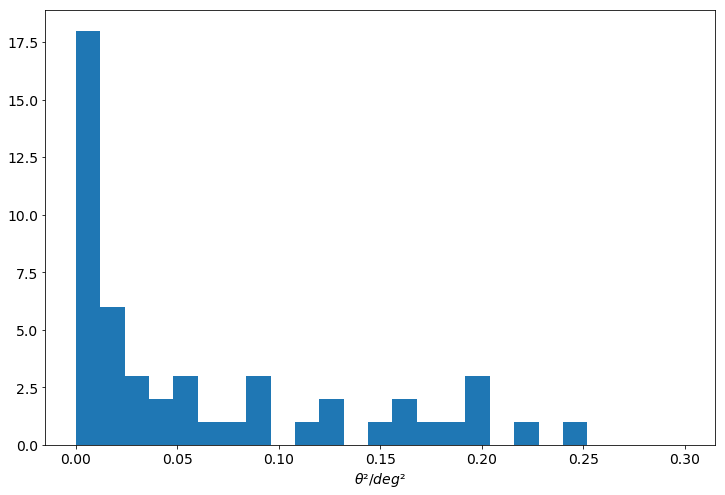

In [ ]:
from astropy.coordinates.angle_utilities import angular_separation
import pandas as pd


df_rec = pd.read_hdf(f.name, key='events/reconstructed')
df_true = pd.read_hdf(f.name, key='events/true')


theta = angular_separation(
    df_rec.az.values * u.deg, df_rec.alt.values * u.deg,
    df_true.az.values * u.deg, df_true.alt.values * u.deg,
)

plt.hist(theta.to(u.deg).value**2, bins=25, range=[0, 0.3])
plt.xlabel(r'$\theta² / deg²$')
None

## ArrayDisplay


(-400, 400)

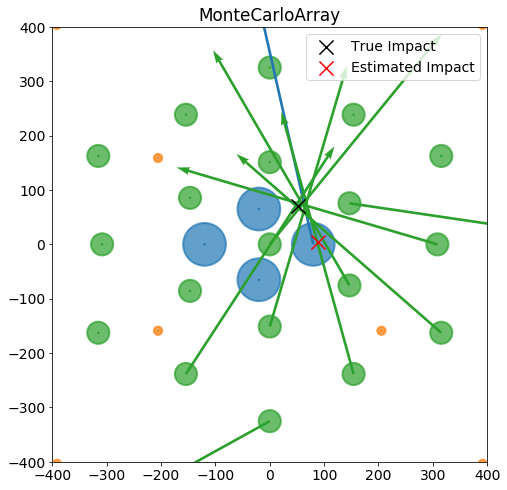

In [ ]:
from ctapipe.visualization import ArrayDisplay


angle_offset = plotting_event.mcheader.run_array_direction[0]


disp = ArrayDisplay(plotting_event.inst.subarray)

disp.set_vector_hillas(
    plotting_hillas,
    time_gradient=plotting_timing,
    angle_offset=angle_offset,
    length=500
)

plt.scatter(
    plotting_event.mc.core_x, plotting_event.mc.core_y,
    s=200, c='k', marker='x', label='True Impact',
)
plt.scatter(
    plotting_stereo.core_x, plotting_stereo.core_y,
    s=200, c='r', marker='x', label='Estimated Impact',
)

plt.legend()
plt.xlim(-400, 400)
plt.ylim(-400, 400)

# LST Mono with output


* Let's use the `HDF5TableWriter` to save the dl1 Hillas parameter data to an hdf5 file
* This is not ideal yet and one of the major points to be discussed in two weeks

In [ ]:
from ctapipe.io import HDF5TableWriter
from ctapipe.core.container import Container, Field

input_url = get_dataset_path('gamma_test_large.simtel.gz')

source = event_source(
    input_url,
    allowed_tels=[1, 2, 3, 4], # only use the first LST
)


calibrator = CameraCalibrator(
    eventsource=source,
)


class EventInfo(Container):
    event_id = Field('event_id')
    obs_id =  Field('obs_id')
    telescope_id = Field('telescope_id')
    


with HDF5TableWriter(filename='hillas.h5', group_name='dl1', mode='w') as writer:

    for event in source:
        print('Id: {}, E = {:1.3f}, Telescopes: {}'.format(event.count, event.mc.energy, len(event.r0.tel)))
    
        calibrator.calibrate(event)
    
        for telescope_id, dl1 in event.dl1.tel.items():      

            camera = event.inst.subarray.tels[telescope_id].camera
            image = dl1.image[0]
            peakpos = dl1.peakpos[0]

            boundary, picture, min_neighbors = cleaning_level[camera.cam_id]

            clean = tailcuts_clean(
                camera, 
                image,
                boundary_thresh=boundary,
                picture_thresh=picture,
                min_number_picture_neighbors=min_neighbors
            )
            
            if clean.sum() < 5:
                continue
            
            event_info = EventInfo(event_id=event.r0.event_id, obs_id=event.r0.obs_id, telescope_id=telescope_id)
            hillas_c = hillas_parameters(camera[clean], image[clean])
            leakage_c = leakage(camera, image, clean)
            timing_c = timing_parameters(camera[clean], image[clean], peakpos[clean], hillas_c)

            writer.write('events', [event_info, event.mc, hillas_c, leakage_c, timing_c])
    


Id: 3, E = 1.864 TeV, Telescopes: 17
Id: 6, E = 0.017 TeV, Telescopes: 2
Id: 11, E = 0.010 TeV, Telescopes: 2
Id: 14, E = 0.121 TeV, Telescopes: 10


In [ ]:
import pandas as pd

df = pd.read_hdf('hillas.h5', key='dl1/events')
df.set_index(['obs_id', 'event_id', 'telescope_id'], inplace=True)
df.head()

In [ ]:
plt.scatter(np.log10(df.energy), np.log10(df.intensity))
plt.xlabel('log10(E / TeV)')
plt.ylabel('log10(intensity)')
None

# Isn't python slow?

* Many of you might have heard: "Python is slow".
* That's trueish.
* All python objects are classes living on the heap, event integers.
* Looping over lots of "primitives" is quite slow compared to other languages.

⇒ Vectorize as much as possible using numpy  
⇒ Use existing interfaces to fast C / C++ / Fortran code  
⇒ Optimize using cython or numba  

**But: "Premature Optimization is the root of all evil" — Donald Knuth**

So profile to find exactly what is slow.

## Why use python then?

* Python works very well as *glue* for libraries of all kinds of languages
* Python has a rich ecosystem for data science, physics, algorithms, astronomy

## Example: Number of Islands

Find all groups of pixels, that survived the cleaning

In [ ]:
from ctapipe.image import toymodel
from ctapipe.instrument import CameraGeometry


camera = CameraGeometry.from_name('LSTCam')

Let's create a toy images with several islands;

In [ ]:
np.random.seed(42)

image = np.zeros(camera.n_pixels)


for i in range(9):
    
    model = toymodel.generate_2d_shower_model(
        centroid=np.random.uniform(-0.8, 0.8, 2),
        width=np.random.uniform(0.05, 0.075),
        length=np.random.uniform(0.1, 0.15),
        psi=np.random.uniform(0, 2 * np.pi) * u.rad,
    )

    new_image, sig, bg = toymodel.make_toymodel_shower_image(
        camera,
        model.pdf, 
        intensity=np.random.uniform(1000, 3000),
        nsb_level_pe=5
    )
    image += new_image

In [ ]:
clean = tailcuts_clean(camera, image, picture_thresh=10, boundary_thresh=5, min_number_picture_neighbors=2)

In [ ]:
disp = CameraDisplay(camera)
disp.image = image
disp.highlight_pixels(clean, color='xkcd:red', linewidth=1.5)
disp.add_colorbar()

In [ ]:
def num_islands_python(camera, clean):
    ''' A breadth first search to find connected islands of neighboring pixels in the cleaning set'''
    
    # the camera geometry has a [n_pixel, n_pixel] boolean array
    # that is True where two pixels are neighbors
    neighbors = camera.neighbor_matrix
    
    island_ids = np.zeros(camera.n_pixels)
    current_island = 0
    
    # a set to remember which pixels we already visited
    visited = set()

    # go only through the pixels, that survived cleaning
    for pix_id in np.where(clean)[0]:
        if pix_id not in visited:
            # remember that we already checked this pixel
            visited.add(pix_id)
            
            # if we land in the outer loop again, we found a new island
            current_island += 1
            island_ids[pix_id] = current_island
            
            # now check all neighbors of the current pixel recursively
            to_check = set(np.where(neighbors[pix_id] & clean)[0])
            while to_check:
                pix_id = to_check.pop()
                
                if pix_id not in visited:    
                    visited.add(pix_id)
                    island_ids[pix_id] = current_island
                    
                    to_check.update(np.where(neighbors[pix_id] & clean)[0])
    
    n_islands = current_island
    return n_islands, island_ids

In [ ]:
n_islands, island_ids = num_islands_python(camera, clean)

In [ ]:
from matplotlib.colors import ListedColormap

cmap = plt.get_cmap('Paired')
cmap = ListedColormap(cmap.colors[:n_islands])
cmap.set_under('k')

disp = CameraDisplay(camera)
disp.image = island_ids
disp.cmap = cmap
disp.set_limits_minmax(0.5, n_islands + 0.5)
disp.add_colorbar()

In [ ]:
%timeit num_islands_python(camera, clean)

In [ ]:
from scipy.sparse.csgraph import connected_components

def num_islands_scipy(camera, clean):
    neighbors = camera.neighbor_matrix_sparse
    
    clean_neighbors = neighbors[clean][:, clean]
    num_islands, labels = connected_components(clean_neighbors, directed=False)
    
    island_ids = np.zeros(camera.n_pixels)
    island_ids[clean] = labels + 1
    
    return num_islands, island_ids

In [ ]:
n_islands_s, island_ids_s = num_islands_scipy(camera, clean)

In [ ]:
disp = CameraDisplay(camera)
disp.image = island_ids_s
disp.cmap = cmap
disp.set_limits_minmax(0.5, n_islands_s + 0.5)
disp.add_colorbar()

In [ ]:
%timeit num_islands_scipy(camera, clean)

**A lot less code, and a factor 3 speed improvement**